In [15]:
from transformers import Dinov2Config, DPTConfig, AutoImageProcessor, DPTForDepthEstimation, DPTModel
import torch
import numpy as np
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
url = "examples/person2.jpeg"
image = Image.open(url)

backbone_config = Dinov2Config.from_pretrained("facebook/dinov2-base", out_features=["stage1", "stage2", "stage3", "stage4"], reshape_hidden_states=False)
config = DPTConfig(backbone_config=backbone_config)
model = DPTModel(config)

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

In [23]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4PxRMZcDLGSLX_DEtMQis3Mb5AWkuMX7_Ug&s'
image = Image.open(requests.get(url, stream=True).raw)

# url = "examples/person1.jpeg"
# image = Image.open(url)
print(image.height, image.width)  # [480, 640]

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)
patch_size = model.config.patch_size

inputs = processor(images=image, return_tensors="pt").to(device)
print(inputs.pixel_values.shape)  # [1, 3, 224, 224]
batch_size, rgb, img_height, img_width = inputs.pixel_values.shape
num_patches_height, num_patches_width = img_height // patch_size, img_width // patch_size
num_patches_flat = num_patches_height * num_patches_width

outputs = model(**inputs)
last_hidden_states = outputs[0]
print(last_hidden_states.shape)  # [1, 1 + 256, 768]
assert last_hidden_states.shape == (batch_size, 1 + num_patches_flat, model.config.hidden_size)

cls_token = last_hidden_states[:, 0, :]
patch_features = last_hidden_states[:, 1:, :].unflatten(1, (num_patches_height, num_patches_width))

cuda
161 312


torch.Size([1, 3, 224, 224])
torch.Size([1, 257, 768])


14 224 224 16 16 257 768


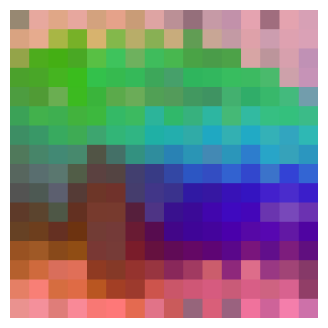

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# get last hidden state tensor and move to cpu numpy
feats = outputs.last_hidden_state if hasattr(outputs, "last_hidden_state") else outputs['last_hidden_state']
feats = feats.detach().cpu().numpy()[0]  # (seq_len, C)

seq_len, C = feats.shape

# infer patch grid from the input image and model patch size
patch_size = model.config.patch_size if hasattr(model.config, "patch_size") else backbone_config.patch_size
H_in, W_in = inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1]
H_p = H_in // patch_size
W_p = W_in // patch_size
print(patch_size, H_in, W_in, H_p, W_p, seq_len, C)

# handle possible cls token
if H_p * W_p == seq_len:
    grid = feats.reshape(H_p, W_p, C)
elif H_p * W_p + 1 == seq_len:
    grid = feats[1:].reshape(H_p, W_p, C)
else:
    # fallback: try perfect square
    s = int(np.sqrt(seq_len))
    if s * s == seq_len:
        grid = feats.reshape(s, s, C)
    elif s * s + 1 == seq_len:
        grid = feats[1:].reshape(s, s, C)
    else:
        raise ValueError(f"Could not infer spatial shape from seq_len={seq_len} and input size {H_in}x{W_in}")

# PCA across channel dimension using sklearn: treat each spatial location as a sample
X = grid.reshape(-1, C).astype(np.float64)  # (H*W, C)
pca = PCA(n_components=3)
proj = pca.fit_transform(X)  # (H*W, 3)

proj_min, proj_max = proj.min(), proj.max()
img_arr = (proj - proj_min) / (proj_max - proj_min + 1e-12)  # normalize to 0-1
img_arr = (img_arr * 255).astype(np.uint8).reshape(grid.shape[0], grid.shape[1], 3)

# resize to 256x256 and display
img = Image.fromarray(img_arr).resize((256, 256), resample=Image.NEAREST)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.show()
